In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np  

import Discriminator as d
import Generator as g
import prepData as prep

### 0. Example: how to load the different layers

In [2]:
N = 5
rank = 15
LR_dim = 128
downscalefactor = 4

# Parent structure: the PolyLayer
test = g.PolyLayer(N, rank, LR_dim, LR_dim)

layerOptions = {'randnormweights':True, 'normalize':False, 'parallel':True}
# Initialize some of the different layers:
testPCPL = g.PolyganCPlayer(N, rank, LR_dim, LR_dim, layerOptions)
testPGFT = g.PolyclassFTTlayer(N, rank, LR_dim, LR_dim, layerOptions)

# Finally the generator
generatorOptions = {'parallel':True, 'workers':4}
testGENR = g.Generator(g.PolyganCPlayer,    N, rank, LR_dim, LR_dim, downscalefactor, layerOptions, generatorOptions)
testGENR = g.Generator(g.PolyclassFTTlayer, N, rank, LR_dim, LR_dim, downscalefactor, layerOptions, generatorOptions)


# Testing the AutoEncoder with the different layers:


In [3]:
# Parameters:
batch_size = 13
N = 5
rank = 15

LR_dim = 128
HR_dim = 512
bottleneck_dim = 32

scalefactor = HR_dim/bottleneck_dim
print(scalefactor)
downscalefactor = bottleneck_dim/LR_dim
print(downscalefactor)

16.0
0.25


## 1. Load data and take a look at the contents

In [4]:
images = prep.load_images_from_folder('000001_01_01')
HRimages = prep.normalize(images)
LRimages = prep.compress_images(HRimages)

In [5]:
HR_loader = DataLoader(HRimages[:20],batch_size=batch_size)#, pin_memory=cuda)
LR_loader = DataLoader(LRimages[:20], batch_size=batch_size)#, pin_memory=cuda)


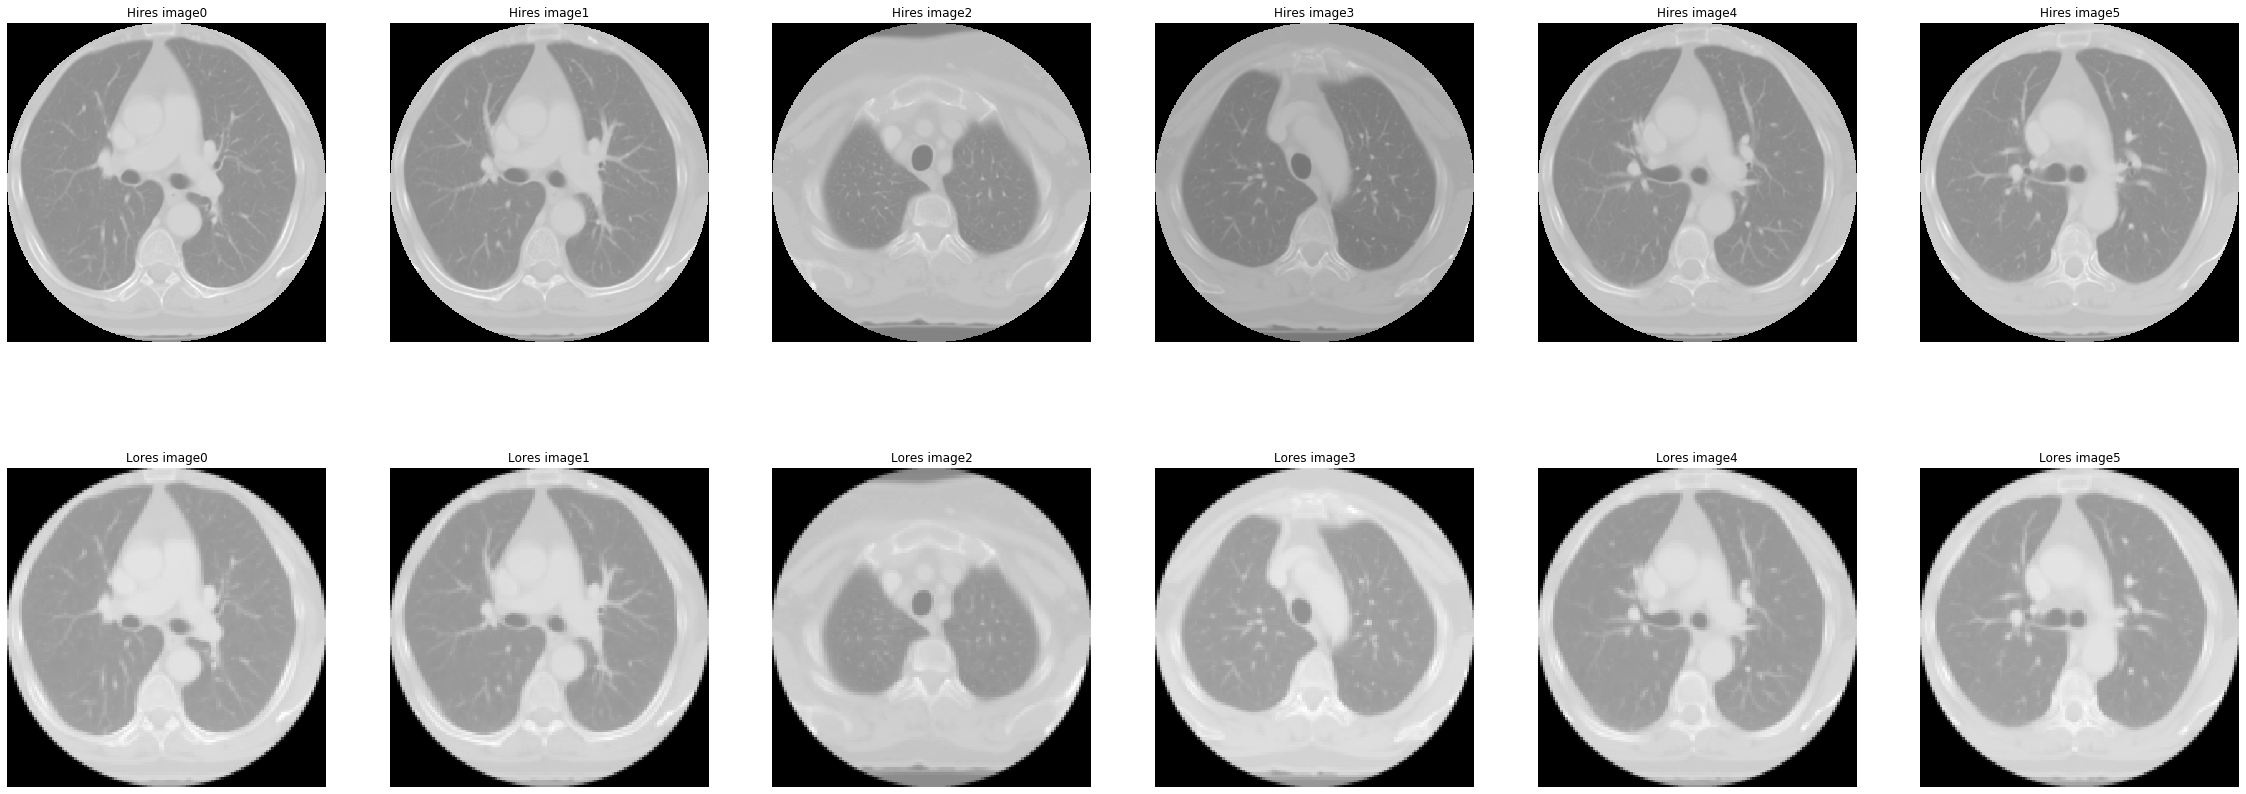

In [6]:
maxim = 6
fig, ax = plt.subplots(2, maxim, figsize=(40,15))
i = 0
for HiResIm, LoResIm in zip(HR_loader, LR_loader):
    for hiresim, loresim in zip(HiResIm, LoResIm):
        ax[0,i].imshow(hiresim, cmap = 'gray')
        ax[0,i].set_title("Hires image" + str(i))
        ax[0,i].axis('off')
        
        ax[1,i].imshow(loresim, cmap = 'gray')
        ax[1,i].set_title("Lores image" + str(i))
        ax[1,i].axis('off')
        if i >= maxim-1:
            break
        i += 1

### 2. The AE model

In [7]:
import time
from tqdm import tqdm

In [8]:
class Autoencoder(torch.nn.Module):
    def __init__(self, layer, layerOptions, generatorOptions):
        super(Autoencoder,self).__init__()
        self.encoder = g.Generator(layer, N, rank, bottleneck_dim, bottleneck_dim, downscalefactor, layerOptions, generatorOptions)
        self.decoder = g.Generator(layer, N, rank, HR_dim, HR_dim, scalefactor, layerOptions, generatorOptions)

    def forward(self, x):
        #print("Input shape = ", x.shape)
        #print(x.sum())
        x = self.encoder(x.float())
        #print("After encoder shape = ", x.shape)
        #print(x.sum())
        x = self.decoder(x)
        #print("After decoder shape = ", x.shape)
        #print(x.sum())
        return x
    
loss_func = torch.nn.MSELoss()


In [9]:
num_epochs = 2
batch_size = 5

def train():
    model.train()
    epoch_loss = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    for epoch in tqdm(range(num_epochs)):
        batch_loss = []
        for HiResIm, LoResIm in zip(HR_loader, LR_loader):
            HiResIm = Variable(HiResIm.unsqueeze_(1).float())
            LoResIm = LoResIm.unsqueeze_(1).float()

            output = model(LoResIm).float()

            loss = loss_func(output, HiResIm).float()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())

        epoch_loss.append(np.mean(batch_loss))
    return epoch_loss


## 3. Training the different layers and generators:

In [20]:
generatorOptions = {'parallel':True, 'workers':3}
layerOptions = {'randnormweights':True, 'normalize':False, 'parallel':False}

#PolyganCPlayer:
model = Autoencoder(g.PolyganCPlayer, layerOptions, generatorOptions)

In [21]:
epoch_loss = train()

100%|██████████| 2/2 [01:43<00:00, 51.08s/it]


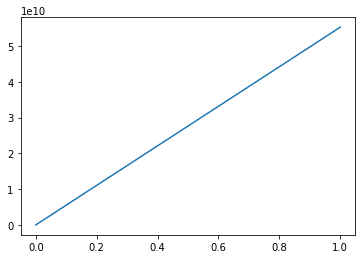

In [22]:
plt.plot(epoch_loss)
plt.show()

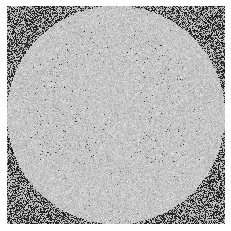

In [23]:
model.eval()
test = torch.tensor(LRimages[0]).reshape(1,1,LR_dim,LR_dim)
out = model(test).reshape(HR_dim,HR_dim)
plt.imshow(out.detach().numpy(), cmap='gray');
plt.axis('off');

In [24]:
# PolyclassFTTlayer:
model = Autoencoder(g.PolyclassFTTlayer, layerOptions, generatorOptions)
epoch_loss = train()

100%|██████████| 2/2 [01:30<00:00, 43.35s/it]


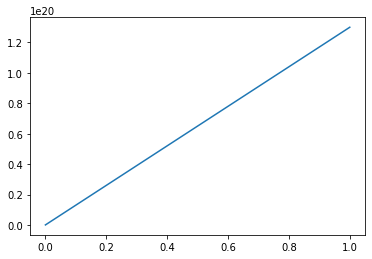

In [25]:
plt.plot(epoch_loss)
plt.show()

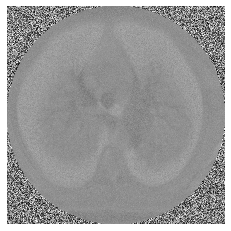

In [26]:
model.eval()
test = torch.tensor(LRimages[0]).reshape(1,1,LR_dim,LR_dim)
out = model(test).reshape(HR_dim,HR_dim)
plt.imshow(out.detach().numpy(), cmap='gray');
plt.axis('off');